In [1]:
from IPython.display import display, Markdown
from itertools import product, combinations, chain
import os
import math

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.stats import norm

In [2]:
if os.path.exists('src'):
    pass
else:
    !pip install lifelines
    !pip install jinja2
    
from lifelines import KaplanMeierFitter

### Глава 11

#### Анализ выживаемости

##### КРИВАЯ ВЫЖИВАЕМОСТИ (метод Каплана—Мейера)

**Кривая выживаемости** задает вероятность пережить любой из моментов времени после некоторого начального события.

Для совокупности. S(t) — это вероятность прожить более t с момента начала наблюдения.

$S(t) = \cfrac{\text{Число переживших момент t}}{\text{Объем совокупности}}$

Возраст, до которого доживает ровно половина совокупности, называется **медианой выживаемости**.

$\hat{S(t)} = \prod{(1 - \cfrac{d_t}{n_t})}$, где $d_t$ - число умерших в момент t, $n_t$ - число наблюдавшихся к моменту t.

Для выборки медиана выживаемости определяется как **наименьшее время, для которого выживаемость меньше 0,5**.

##### Стандартная ошибка и доверительные интервалы выживаемости

стандартная ошибка выживаемости (формула Гринвуда): $S_{\hat{S}(t)} = \hat{S}(t)\sqrt{\sum{\cfrac{d_{t_i}}{n_{t_i}(n_{t_i} - d_{t_i})}}}$, где сумма берется по всем моментам $t_i$
, от нуля до t включительно.

Доверительный интервал для выживаемости в момент t: $\hat{S}(t) - z_{\alpha}S_{\hat{S}(t)} < S(t) < \hat{S}(t) + z_{\alpha}S_{\hat{S}(t)}$, для 95% доверительного интервала $z_{\alpha=0.05} = 1.960$

** значения, большие единицы, следует заменить на единицу, а меньшие нуля — на ноль. 

Существует и несколько более сложный способ, он позволяет рассчитать доверительный интервал точнее. Возьмем двойной логарифм $ln(-ln\hat{S}(t))$. В отличие от $\hat{S}(t)$, эта величина не должна лежать в пределах от 0 до 1. Затем вычислим для нее стандартную ошибку, после чего вернемся к исходной функции $\hat{S}(t)$.

Стандартная ошибка для логарифмической формы выживаемости: $S_{ln(-ln\hat{S}(t))}=\sqrt{\cfrac{1}{(ln\hat{S}(t))^2}\sum{\cfrac{d_t}{n_t(n_t-d_t)}}}$

Тогда $100(1 – /alpha)$ процентный доверительный интервал для S(t) определяется неравенством: $\hat{S}(t)^{exp(-z_{\alpha}S_{ln[-ln\hat{S}(t)]})} < S(t) < \hat{S}(t)^{exp(+z_{\alpha}S_{ln[-ln\hat{S}(t)]})}$

##### СРАВНЕНИЕ ДВУХ КРИВЫХ ВЫЖИВАЕМОСТИ

Нулевая гипотеза состоит в том, что в обеих группах выживаемость одинакова. 

*Если бы не было выбывания и все больные наблюдались равное время, нам бы подошел анализ таблиц сопряженности. Если бы все больные наблюдались вплоть до смерти, можно было бы сравнить выживаемость в обеих группах с помощью непараметрических методов, например рангового критерия Манна—Уитни или метода Крускала—Уоллиса.*

**логранговый критерий**

* Две сравниваемые выборки независимы и случайны.
* Выбывание в обеих выборках одинаково.
* Функции выживаемости связанысоотношением: $S_2(t)=[S_1(t)]^\Psi$

$\Psi$ - отношением смертности. $\Psi=1$ - кривые выживаемости совпадают. $\Psi < 1$ - люди во 2-й выборке умирают позже, чем в 1-й. И наоборот, если $\Psi > 1$, позже умирают в 1-й выборке.

$E_{1t}=\cfrac{n_{1t}d_{обt}}{n_{обt}}$ - ожидаемое число умерших в первой группе в момент времени t; $n_{1t}$ — число наблюдавшихся в 1-й группе к этому моменту, $d_{обt}$ — общее число смертей в этот момент в обеих группах, $n_{обt}$ — общее число наблюдавшихся к этому моменту. *Выбывшие учитываются косвенно — влияя на число наблюдавшихся.*

$U_L = \sum{(d_{1t} - E_{1t})}$ - сумма разности наблюдаемого и ожидаемого числа умерших. Сумма берется по всем моментам t, когда хотя бы одна смерть наступала в любой из двух групп. Если $U_L$ достаточно велико, гипотезу об отсутствии различий выживаемости следует отклонить.

$U_L$ приближенно подчиняется нормальному распределению со стандартным отклонением: $S_{U_L} = \sqrt{\sum{\cfrac{n_{1t}n_{2t}d_{обt}(n_{обt}-d_{обt})}{n_{обt}^2(n_{обt}-1)}}}$ где, как и раньше, сумма берется по всем моментам t, когда наблюдалась хотя бы одна смерть. 

$z = \cfrac{U_L}{S_{U_L}}$ 

Распределение z приблизительно нормально, поэтому сравниваем эту величину с критическим значением для стандартного нормального распределения.

**Поправка Йейтса для логрангового критерия**

$z = \cfrac{|U_L|-\cfrac{1}{2}}{S_{U_L}}$ 

**КРИТЕРИЙ ГЕХАНА (обобщение критерия Уилкоксона)**

Он не требует постоянства отношения смертности, но на его результаты слишком сильно влияет число ранних смертей.

Критерий Гехана вычисляют так. Каждого больного из 1-й группы сравнивают с каждым больным из 2-й группы. Результат сравнения оценивают как +1, если больной из 1-й группы наверняка прожил дольше, –1, если он наверняка прожил меньше, и 0, если невозможно наверняка сказать, кто из них прожил дольше. Последнее возможно в трех случаях: если оба выбыли, если один выбыл до того, как другой умер, и если время наблюдения одинаково. 

Результаты сравнения для каждого больного суммируют; эту сумму мы обозначим h. В свою очередь сумма всех h дает величину $U_W$, стандартная ошибка которой определяется по формуле:

$S_{U_W}=\sqrt{\cfrac{n_1n_2\sum{h^2}}{(n_1+n_2)((n_1+n_2+1))}}$

$z = \cfrac{U_W}{S_{U_W}}$ 

с посправкой Йейтса $z = \cfrac{|U_W|-\cfrac{1}{2}}{S_{U_W}}$ 

**Какой критерий предпочесть?**

Логранговый критерий предпочтительнее критерия Гехана, если справедливо предположение о постоянном отношении смертности: $S_2(t)=[S_1(t)]^\Psi$

Установить, выполняется ли это условие, можно, нарисовав графики $ln[-ln(\hat{S}_1(t))]$ и $ln[-ln(\hat{S}_2(t))]$ — они должны быть параллельны. Во всяком случае, кривые выживаемости не должны пересекаться.

##### ЧУВСТВИТЕЛЬНОСТЬ И ОБЪЕМ ВЫБОРКИ

Прежде всего следует оценить необходимое число исходов (смертей, рецидивов и т. д.).

$d = (z_{1-\alpha/2} + z_{1-\beta})^2(\cfrac{1+\Psi}{1-\Psi})^2$, где $\Psi$ — отношение смертности, а $z_{1-\alpha/2}$ и $z_{1-\beta}$ — соответствующие $1-\alpha/2$ и $1-\beta$ значения стандарного нормального распределения.

$\Psi$ можно оценить как $\Psi = \cfrac{lnS_2(\infty)}{lnS_1(\infty)}$, где $S_1(\infty)$ и $S_2(\infty)$ — выживаемость в 1-й и 2-й группах к концу наблюдения.

Теперь можно найти n — численность каждой из групп: $n = \cfrac{d}{2-S_1(\infty)-S_2(\infty)}$

Таким образом, по ожидаемым долям доживших до завершения эксперимента мы можем найти объем n каждой из выборок.

Общая формула, из которой можно вывести две вышеприведенные:

$z_{1-\beta} = \cfrac{|\Psi - 1|\sqrt{N(1-\omega)\varphi[(1-S_1)+\varphi(1-S_2)]/(1+\varphi)}}{1+\varphi\Psi} - z_{1-\alpha/k}$

где k=1 в случае односторонней гипотезы, k=2 - двухсторонней, $\omega$ - пропорция утерянных данных в ходе эксперимента,$\varphi=\cfrac{N_2}{N_1}$ - отношение численности двух групп.

Для случая проверки двухсторонней гипотезы, группы с одинаковой численностью и отсутствуют потерянные данные формула упрощается до:

$z_{1-\beta} = \cfrac{|\Psi - 1|\sqrt{N[2-S_1-S_2]/2}}{1+\Psi} - z_{1-\alpha/2}$

#### ЗАДАЧИ

**11.1.**

Амбулаторное лечение пожилых людей дешевле стационарного. Однако позволяет ли амбулаторное наблюдение достаточно надежно выявлять тех, кто нуждается в госпитализации? Для оценки общего состояния пожилого человека предложена так называемая шкала повседневной работы по дому (IADL, Instrumental Activities of Daily Living). Один из разделов исследования Б. Келлер и Дж. Поттер (В. Keller, J. Potter. Predictors of mortality in outpatient geriatric evaluation and management clinic patients. J. Gerontology, 49:M246—M251, 1994) был посвящен изучению прогностической ценности этой шкалы.

В исследование были включены люди примерно одного возраста (средний возраст 78,4 года, стандартное отклонение 7,2 года), разделенные на 2 группы: с высокой и низкой оценкой по шкале повседневной работы по дому. В результате 4-летнего наблюдения были получены следующие данные:

Высокая оценка:

Время, мес|Умерли или выбыли
-|-
14|1
20|2
24|3
25+|1
28|1
30|2
36+|1
37+|1
38|2
42+|1
43+|1
48|2
48+|62

Низкая оценка:

Время, мес|Умерли или выбыли
-|-
6|2
12|2
18|4
24|1
26+|1
28|4
32|4
34+|2
36|4
38+|3
42|3
46+|2
47|3
48|2
48+|23

Оцените статистическую значимость различий в выживаемости двух групп.

In [3]:
inp_1 = """14|1
20|2
24|3
25+|1
28|1
30|2
36+|1
37+|1
38|2
42+|1
43+|1
48|2
48+|62"""

inp_2 = """6|2
12|2
18|4
24|1
26+|1
28|4
32|4
34+|2
36|4
38+|3
42|3
46+|2
47|3
48|2
48+|23"""

def inp_to_df(inp: str) -> pd.DataFrame:
    data = []
    for a, b in [x.split("|") for x in inp.split()]:
        n = int(b)
        if a[-1] == "+":
            data.append([[int(a[:-1]), 0]]*n)
        else:
            data.append([[int(a), 1]]*n)

    return pd.DataFrame(data=list(chain(*data)), columns=["T", "E"])

df = pd.concat([inp_to_df(inp_1).assign(group="Высокая оценка"), inp_to_df(inp_2).assign(group="Низкая оценка")]).reset_index(drop=True)

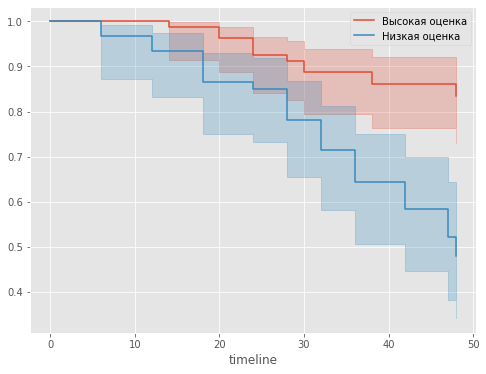

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

kmf = KaplanMeierFitter()

for name, grouped_df in df.groupby('group'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot_survival_function(ax=ax)

In [5]:
from lifelines.statistics import logrank_test
groups = df['group']
ix = (groups == "Высокая оценка")

T = df['T']
E = df['E']

results = logrank_test(T[ix], T[~ix], E[ix], E[~ix])

results

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.36 <0.005     15.74

Различия выживаемости статистически значимы.

**11.2.**

Ф. Джирард и соавт. (Р. Girard et al. Surgery for pulmonary metastases: who are the 10 years survivors? Cancer, 74:2791—2797, 1994) изучили выживаемость 34 больных после резекции легкого по поводу метаетазов. Результаты приведены в таблице на следующей странице. Постройте кривую выживаемости и ее 95% доверительную область.

Выживаемость после резекции легкого по поводу метастазов:

Месяц после операции|Число умерших и выбывших
-|-
1|1
2|1
3|3
4|1
5|1
6|1
7|2
8|1
9|1
10+|1
11+|2
12|2
13|1
15|1
16|3
20|3
21|1
25+|1
28|1
34|1
36+|1
48+|1
56|1
62|1
84|1

In [6]:
inp = """1|1
2|1
3|3
4|1
5|1
6|1
7|2
8|1
9|1
10+|1
11+|2
12|2
13|1
15|1
16|3
20|3
21|1
25+|1
28|1
34|1
36+|1
48+|1
56|1
62|1
84|1"""

df = inp_to_df(inp)

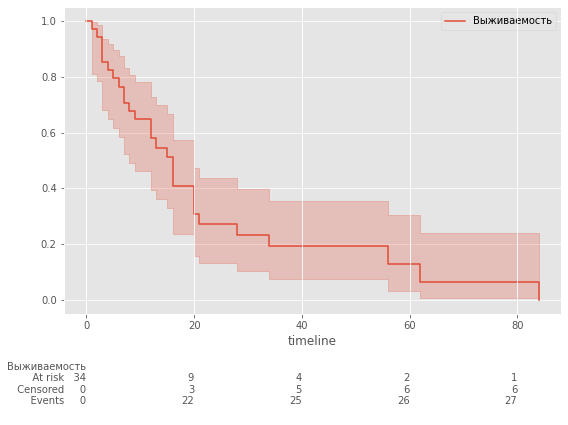

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
kmf.fit(df["T"], df["E"], label="Выживаемость", alpha=0.05)
kmf.plot_survival_function(ax=ax, at_risk_counts=True)
plt.tight_layout()

In [8]:
# доверительный интервал вычиляется при помощи экспоненциальной формулы Гринвуда (log-log)

kmf.confidence_interval_

,Выживаемость_lower_0.95,Выживаемость_upper_0.95
0.0,1.000000,1.000000
1.0,0.809010,0.995804
2.0,0.784699,0.984955
3.0,0.682146,0.935994
4.0,0.648748,0.916570
5.0,0.616102,0.896087
6.0,0.584184,0.874695
7.0,0.522370,0.829592
8.0,0.492405,0.806019
9.0,0.463028,0.781831


**11.3.**
Основная причина детской смертности в Японии — онкологические заболевания. Позволяют ли современные методы лечения продлить жизнь детей? В. Аджики и соавт. (W. Ajiki et al. Survival rates of childhood cancer patients in Osaka, Japan, 1975–1984. Jpn. J. Cancer Res., 86:13–20, 1995) сравнили выживаемость (с момента постановки диагноза) детей с онкологическими заболеваниями в период 1975—1979 гг. с выживаемостью в период 1980—1984гг.

1975–1979 гг.:

Время|Умерли или выбыли
-|-
2|3
4|4
6|3
8|4
10+|1
12|2
14|3
16+|1
18|2
22+|1
24|1
30|2
36|1
52+|1
54|1
56|1
60|1
60+|18

1980–1984гг.:

Время|Умерли или выбыли
-|-
2|4
4|1
6|3
8|10
12|4
14|3
18+|1
20+|1
22|2
24|1
30|2
36|3
48|2
54+|1
56|2
60|1
60+|9

(а) Постройте кривые выживаемости и 95% доверительные интервалы, (б) Найдите медианы выживаемости, (в) Оцените статистическую значимость различий выживаемости, (г) Определите чувствительность логрангового критерия с уровнем значимости α = 0,05, предполагая, что S(∞) = S(60). (д) Вычислите общее число смертей и численность групп, при которых чувствительность логрангового критерия составит 0,80 при условии, что S(∞) снизилась с 0,40 в период 1975—1979 гг. до 0,20 или 0,15 в 1980–1984 гг.

In [9]:
inp_1 = """2|3
4|4
6|3
8|4
10+|1
12|2
14|3
16+|1
18|2
22+|1
24|1
30|2
36|1
52+|1
54|1
56|1
60|1
60+|18"""

inp_2 = """2|4
4|1
6|3
8|10
12|4
14|3
18+|1
20+|1
22|2
24|1
30|2
36|3
48|2
54+|1
56|2
60|1
60+|9
"""

df = pd.concat([inp_to_df(inp_1).assign(group="1975–1979 гг."), inp_to_df(inp_2).assign(group="1980–1984гг.")]).reset_index(drop=True)

1975–1979 гг.: median = 36.0, S1(60.0)=0.417, n1=50
1980–1984гг.: median = 14.0, S2(60.0)=0.212, n2=50


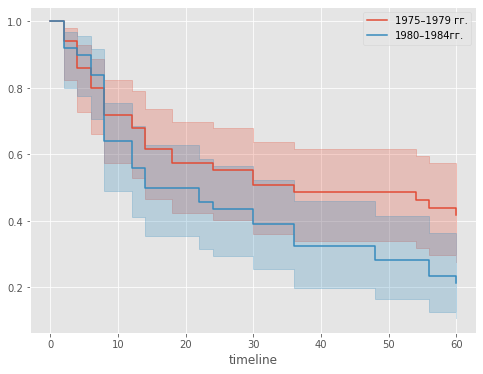

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

kmf = KaplanMeierFitter()
S = []

for i, (name, grouped_df) in enumerate(df.groupby('group'), start=1):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot_survival_function(ax=ax)
    st = kmf.survival_function_.iloc[-1]
    S.append(st.values[0])
    print(f"{name}: median = {kmf.median_survival_time_}, S{i}({st.name})={S[-1]:.3f}, n{i}={grouped_df.shape[0]}")

In [11]:
from lifelines.statistics import logrank_test
groups = df['group']
ix = (groups == "1975–1979 гг.")

T = df['T']
E = df['E']

results = logrank_test(T[ix], T[~ix], E[ix], E[~ix])

results

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.16 0.08      3.72

Различия выживаемости статистически не значимы.

In [12]:
def power(N, S1, S2):
    Psi = math.log(S2)/math.log(S1)
    return norm.cdf(abs(Psi - 1)*(N*(2 - S1 - S2)/2)**.5/(1 + Psi) - norm.ppf(1-0.05/2))

print(f"power={power(df.shape[0], *S):.3f}")

power=0.636


Чувствительность ($1-\beta$) составляет 0.636

In [13]:
def n_d(power, S1, S2):
    Psi = math.log(S2)/math.log(S1)

    d = (norm.ppf(power) + norm.ppf(1-0.05/2))**2*((1+Psi)/(1-Psi))**2
    N = d/(2 - S1 - S2) * 2

    return d, N

In [14]:
# (д) 1.
# power = 0.8, S1 = 0.4, S2 = 0.2

d, N = n_d(0.8, 0.4, 0.2)

print(f"N={math.ceil(N)}, d={round(d)}")

N=149, d=104


In [15]:
# (д) 2.
# power = 0.8, S1 = 0.4, S2 = 0.15

d, N = n_d(0.8, 0.4, 0.15)

print(f"N={math.ceil(N)}, d={round(d)}")

N=90, d=65


Число смертей 104, суммарная численность групп 149 (для снижения S(∞) до 0,20),

Число смертей 65, суммарная численность групп 90 (для снижения S(∞) до 0,15).